## 1. Preparation 

In [1]:
from __future__ import print_function
import pickle
import os.path
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import linregress
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# If modifying these scopes, delete the file token.pickle.
SCOPES = ['https://www.googleapis.com/auth/spreadsheets.readonly']

def get_values(SAMPLE_SPREADSHEET_ID, SAMPLE_RANGE_NAME):
    """Shows basic usage of the Sheets API.
    Prints values from a sample spreadsheet.
    """
    creds = None
    # The file token.pickle stores the user's access and refresh tokens, and is
    # created automatically when the authorization flow completes for the first
    # time.
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    # If there are no (valid) credentials available, let the user log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                'credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        # Save the credentials for the next run
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)

    service = build('sheets', 'v4', credentials=creds)

    # Call the Sheets API
    sheet = service.spreadsheets()
    result = sheet.values().get(spreadsheetId=SAMPLE_SPREADSHEET_ID,
                                range=SAMPLE_RANGE_NAME).execute()
    values = result.get('values', [])

    if not values:
        print('No data found.')
    
    return values

## 2.0 Read Spreasheets data

In [3]:
# TODO: change UID of the sheet to the correct one
SHEET_ID = '1yJ8Su5zcyAOADDU_YXYTFqkTbM_siwNYuxESR3fgBc8'

In [4]:
# TODO: change UID of the sheet to the correct one
# Read attaquants
attaquants = get_values(SHEET_ID, 'Attaquants')
attaquants = pd.DataFrame(attaquants[2:])
attaquants = attaquants.dropna(subset=[0,36]) # Drop if no name or nan cap hits
attaquants = attaquants[attaquants[36]!='']
attaquants['pos'] = 'A'

# Read defenseurs
defenseurs = get_values(SHEET_ID, 'Defenseurs')
defenseurs = pd.DataFrame(defenseurs[2:])
defenseurs = defenseurs.dropna(subset=[0,36]) # Drop if no name or nan cap hits
defenseurs = defenseurs[defenseurs[36]!='']
defenseurs['pos'] = 'D'

# Read gardiens
gardiens = get_values(SHEET_ID, 'Gardiens')
gardiens = pd.DataFrame(gardiens[1:])
gardiens = gardiens.dropna(subset=[0,21]) # Drop if no name or nan cap hits
gardiens = gardiens[gardiens[21]!='']
gardiens['pos'] = 'G'

In [5]:
nhl = pd.concat([attaquants[[4,5,'pos',13,36,37]].rename({4: 'name', 5: 'status', 13: 'proj', 36: 'cap_hit', 37: 'end'}, axis=1), 
                 defenseurs[[4,5,'pos',13,36,37]].rename({4: 'name', 5: 'status', 13: 'proj', 36: 'cap_hit', 37: 'end'}, axis=1), 
                 gardiens[[1,2,'pos',12,21,22]].rename({1: 'name', 2: 'status', 12: 'proj', 21: 'cap_hit', 22: 'end'}, axis=1)],
                 ignore_index=True)
nhl['cap_hit'] = nhl['cap_hit'].replace(',', '', regex=True).astype(int)
nhl['proj'] = nhl['proj'].astype(int)
nhl = nhl[nhl.status != 'x']

## 3.0 Knapsack
https://medium.com/@kangeugine/fantasy-football-as-a-data-scientist-part-2-knapsack-problem-6b7083955e93

In [6]:
from pulp import *

player = [str(i) for i in range(nhl.shape[0])]
point = {str(i): int(nhl['proj'].iloc[i]) for i in range(nhl.shape[0])} 
cost = {str(i): int(nhl['cap_hit'].iloc[i]) for i in range(nhl.shape[0])}
att = {str(i): 1 if nhl['pos'].iloc[i] == 'A' else 0 for i in range(nhl.shape[0])}
defe = {str(i): 1 if nhl['pos'].iloc[i] == 'D' else 0 for i in range(nhl.shape[0])}
goal = {str(i): 1 if nhl['pos'].iloc[i] == 'G' else 0 for i in range(nhl.shape[0])}
xi = {str(i): 1 for i in range(nhl.shape[0])}

In [7]:
prob = LpProblem("Fantasy Hockey", LpMaximize)
player_vars = LpVariable.dicts("Players", player, cat=LpBinary)

/home/cenoi/miniconda3/envs/pool/lib/python3.7/site-packages/pulp/pulp.py:1199: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [8]:
# objective function
prob += lpSum([point[i] * player_vars[i] for i in player]), "Total Cost"

In [9]:
# constraint
prob += lpSum([player_vars[i] for i in player]) == 22, "Total 20 Players"
prob += lpSum([cost[i] * player_vars[i] for i in player]) <= 81500000, "Total Cost"
prob += lpSum([att[i] * player_vars[i] for i in player]) <= 13, "Less than 13 att"
prob += lpSum([defe[i] * player_vars[i] for i in player]) <= 7, "Less than 7 def"
prob += lpSum([goal[i] * player_vars[i] for i in player]) <= 2, "Less than 2 goalers"

In [10]:
%%time
# solve
status = prob.solve()

CPU times: user 0 ns, sys: 15.6 ms, total: 15.6 ms
Wall time: 108 ms


In [11]:
# The status of the solution is printed to the screen
print("Status:", LpStatus[prob.status])

Status: Optimal


In [12]:
selection = {}
for v in prob.variables():
    index = int(v.name.split("_")[1])
    selection[index] = v.varValue
#     print(v.name, "=", v.varValue)

In [13]:
nhl['label'] = 0.0
nhl = nhl.reset_index()
for i in selection:
    nhl.loc[i, 'label'] = selection[i]

In [14]:
XI = nhl[nhl['label'] == 1.0]
TOTAL_POINTS = XI['proj'].sum()
TOTAL_COST = XI['cap_hit'].sum()
TOTAL_PLAYERS = XI.shape[0]
print("Total points: {}, cost: {}$, and with players: {}".format(TOTAL_POINTS, TOTAL_COST, TOTAL_PLAYERS))
(XI[['name','pos','proj','cap_hit', 'end']]
 .sort_values(['pos'])
 .reset_index(drop=True))

Total points: 909, cost: 81242023$, and with players: 22


,name,pos,proj,cap_hit,end
0,Artemi Panarin,A,67,11642857,26
1,Kirby Dach,A,31,925000,22
2,Jack Hughes,A,33,925000,22
3,Kailer Yamamoto,A,39,894166,21
4,Alexis Lafreniere,A,41,925000,23
5,David Perron,A,43,4000000,22
6,Robert Thomas,A,35,894166,21
7,J.T. Miller,A,51,5250000,23
8,Jake Guentzel,A,54,6000000,24
9,Brayden Point,A,54,6750000,22


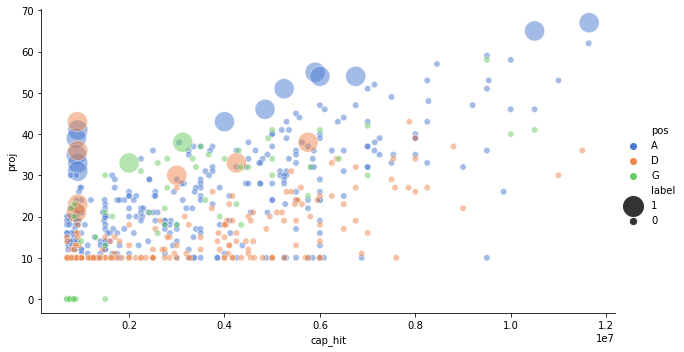

In [15]:
sns.relplot(x="cap_hit", y="proj", 
            hue="pos", size='label',
            size_order=[1,0],
            sizes=(40, 400), alpha=.5, 
            palette="muted", height=5, aspect=1.75,
            data=nhl)

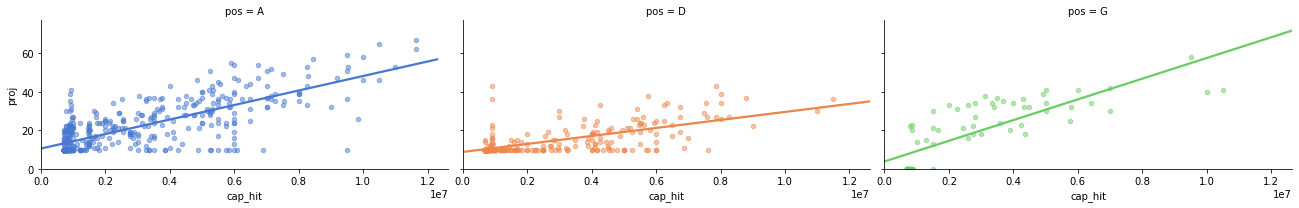

In [16]:
sns.lmplot(x="cap_hit", y="proj", col="pos", hue="pos", 
           data=nhl, aspect=2,
           col_wrap=4, ci=None, palette="muted", height=3,
#            hue_order=['DEF','GK','MID', 'STR'],
#            col_order=['DEF','GK','MID', 'STR'],
           scatter_kws={"s": 20, "alpha": 0.5})
plt.xlim(0, 1000000+max(nhl.cap_hit));
plt.ylim(0, 10+max(nhl.proj));

In [17]:
slope_inter = {}
for pos in np.unique(nhl.pos):
    pos_data = nhl[(nhl.pos == pos) & (nhl.proj >= 0)].reset_index(drop=True)
    output = linregress(pos_data['cap_hit'],pos_data['proj'])
    print("For {}, y = {:f}x + {:0.3f}".format(pos, 1000000*output.slope, output.intercept))
    slope_inter[pos] = {"slope":output.slope, "intercept":output.intercept}

For A, y = 3.762960x + 10.549
For D, y = 2.076040x + 8.778
For G, y = 5.366561x + 3.838


## 4.0 Script

In [6]:
from __future__ import print_function
import pickle
import os.path
import pandas as pd
import numpy as np
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from pulp import *


def get_values(SAMPLE_SPREADSHEET_ID, SAMPLE_RANGE_NAME):
    """Shows basic usage of the Sheets API.
    Prints values from a sample spreadsheet.
    """
    creds = None
    # The file token.pickle stores the user's access and refresh tokens, and is
    # created automatically when the authorization flow completes for the first
    # time.
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    # If there are no (valid) credentials available, let the user log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                'credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        # Save the credentials for the next run
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)

    service = build('sheets', 'v4', credentials=creds)

    # Call the Sheets API
    sheet = service.spreadsheets()
    result = sheet.values().get(spreadsheetId=SAMPLE_SPREADSHEET_ID,
                                range=SAMPLE_RANGE_NAME).execute()
    values = result.get('values', [])

    if not values:
        print('No data found.')
    
    return values


def get_selection(nhl):
    # Setup
    player = [str(i) for i in range(nhl.shape[0])]
    point = {str(i): int(nhl['proj'].iloc[i]) for i in range(nhl.shape[0])} 
    cost = {str(i): int(nhl['cap_hit'].iloc[i]) for i in range(nhl.shape[0])}
    end = {str(i): int(nhl['end'].iloc[i]) for i in range(nhl.shape[0])} 
    att = {str(i): 1 if nhl['pos'].iloc[i] == 'A' else 0 for i in range(nhl.shape[0])}
    defe = {str(i): 1 if nhl['pos'].iloc[i] == 'D' else 0 for i in range(nhl.shape[0])}
    goal = {str(i): 1 if nhl['pos'].iloc[i] == 'G' else 0 for i in range(nhl.shape[0])}
    xi = {str(i): 1 for i in range(nhl.shape[0])}
    prob = LpProblem("Fantasy Hockey", LpMaximize)
    player_vars = LpVariable.dicts("Players", player, cat=LpBinary)
    
    # Objective function
    prob += lpSum([point[i] * player_vars[i] for i in player]), "Total Cost"
    
    # Constraints
    spots_to_fill = 22 - nhl[nhl.status == 'o'].shape[0]
    prob += lpSum([player_vars[i] for i in player]) == spots_to_fill, "Total {spots_to_fill} Players"
    money_left = nhl[nhl.status == 'o']['cap_hit'].sum()
    prob += lpSum([cost[i] * player_vars[i] for i in player]) <= 81500000 - money_left, "Total Cost"
    prob += lpSum([att[i] * player_vars[i] for i in player]) <= 13, "Less than 13 att"
    prob += lpSum([defe[i] * player_vars[i] for i in player]) <= 7, "Less than 7 def"
    prob += lpSum([goal[i] * player_vars[i] for i in player]) <= 2, "Less than 2 goalers"
    
    # Solve
    status = prob.solve()
    
    # Selection
    selection = {}
    for v in prob.variables():
        index = int(v.name.split("_")[1])
        selection[index] = v.varValue
    nhl['label'] = 0.0
    nhl = nhl.reset_index()
    for i in selection:
        nhl.loc[i, 'label'] = selection[i]
        
    # Display
    XI = nhl[nhl['label'] == 1.0]
    TOTAL_POINTS = XI['proj'].sum()
    TOTAL_COST = XI['cap_hit'].sum()
    TOTAL_PLAYERS = XI.shape[0]
    '''
    TODO: Print current players, and players to add
    '''
    print("Total points: {}\ncost: {}\nplayers: {}".format(TOTAL_POINTS, TOTAL_COST, TOTAL_PLAYERS))
    print('---------------------------------------------')
    print(XI[['name','pos','proj','cap_hit', 'end']][XI['pos']=='A'].sort_values(['pos']).reset_index(drop=True))
    print('---------------------------------------------')
    print(XI[['name','pos','proj','cap_hit', 'end']][XI['pos']=='D'].sort_values(['pos']).reset_index(drop=True))
    print('---------------------------------------------')
    print(XI[['name','pos','proj','cap_hit', 'end']][XI['pos']=='G'].sort_values(['pos']).reset_index(drop=True))
    print('---------------------------------------------\n')

    return nhl, XI

In [8]:
def main():
    # Read attaquants
    attaquants = get_values(SHEET_ID, 'Attaquants')
    attaquants = pd.DataFrame(attaquants[2:])
    attaquants = attaquants.dropna(subset=[0,36]) # Drop if no name or nan cap hits
    attaquants = attaquants[attaquants[36]!='']
    attaquants['pos'] = 'A'

    # Read defenseurs
    defenseurs = get_values(SHEET_ID, 'Defenseurs')
    defenseurs = pd.DataFrame(defenseurs[2:])
    defenseurs = defenseurs.dropna(subset=[0,36]) # Drop if no name or nan cap hits
    defenseurs = defenseurs[defenseurs[36]!='']
    defenseurs['pos'] = 'D'

    # Read gardiens
    gardiens = get_values(SHEET_ID, 'Gardiens')
    gardiens = pd.DataFrame(gardiens[1:])
    gardiens = gardiens.dropna(subset=[0,21]) # Drop if no name or nan cap hits
    gardiens = gardiens[gardiens[21]!='']
    gardiens['pos'] = 'G'
    
    # Preprocessing
    nhl = pd.concat([attaquants[[4,5,'pos',13,36,37]].rename({4: 'name', 5: 'status', 13: 'proj', 36: 'cap_hit', 37: 'end'}, axis=1), 
                     defenseurs[[4,5,'pos',13,36,37]].rename({4: 'name', 5: 'status', 13: 'proj', 36: 'cap_hit', 37: 'end'}, axis=1), 
                     gardiens[[1,2,'pos',12,21,22]].rename({1: 'name', 2: 'status', 12: 'proj', 21: 'cap_hit', 22: 'end'}, axis=1)],
                     ignore_index=True)
    nhl['cap_hit'] = nhl['cap_hit'].replace(',', '', regex=True).astype(int)
    nhl['proj'] = nhl['proj'].astype(int)
    nhl = nhl[nhl.status != 'x'] # Only look at available players
    
    # Knapsack 1st tier
    print('TIER 1\n')
    nhl_selection1, X1 = get_selection(nhl)
    X1['tier'] = 1
    
    # Knapsack 2nd tier
    nhl_selection1 = nhl_selection1[nhl_selection1.label == 0.0]
    nhl_selection1 = nhl_selection1.drop(['index'], axis=1)
    print('TIER 2\n')
    nhl_selection2, X2 = get_selection(nhl_selection1)
    X2['tier'] = 2
    
    # Knapsack 3rd tier
    nhl_selection2 = nhl_selection2[nhl_selection2.label == 0.0]
    nhl_selection2 = nhl_selection2.drop(['index'], axis=1)
    print('TIER 3\n')
    nhl_selection3, X3 = get_selection(nhl_selection2)
    X3['tier'] = 3
    
    # Knapsack 4th tier
    nhl_selection3 = nhl_selection3[nhl_selection3.label == 0.0]
    nhl_selection3 = nhl_selection3.drop(['index'], axis=1)
    print('TIER 4\n')
    nhl_selection4, X4 = get_selection(nhl_selection3)
    X4['tier'] = 4
    
    # Knapsack 5th tier
    nhl_selection4 = nhl_selection4[nhl_selection4.label == 0.0]
    nhl_selection4 = nhl_selection4.drop(['index'], axis=1)
    print('TIER 5\n')
    nhl_selection5, X5 = get_selection(nhl_selection4)
    X5['tier'] = 5
    
    # Knapsack 6th tier
    nhl_selection5 = nhl_selection5[nhl_selection5.label == 0.0]
    nhl_selection5 = nhl_selection5.drop(['index'], axis=1)
    print('TIER 6\n')
    nhl_selection6, X6 = get_selection(nhl_selection5)
    X6['tier'] = 6
    
    # Knapsack 7th tier
    nhl_selection6 = nhl_selection6[nhl_selection6.label == 0.0]
    nhl_selection6 = nhl_selection6.drop(['index'], axis=1)
    print('TIER 7\n')
    nhl_selection7, X7 = get_selection(nhl_selection6)
    X7['tier'] = 7
    
    # Knapsack 8th tier
    nhl_selection7 = nhl_selection7[nhl_selection7.label == 0.0]
    nhl_selection7 = nhl_selection7.drop(['index'], axis=1)
    print('TIER 8\n')
    nhl_selection8, X8 = get_selection(nhl_selection7)
    X8['tier'] = 8
    
    # Knapsack 9th tier
    nhl_selection8 = nhl_selection8[nhl_selection8.label == 0.0]
    nhl_selection8 = nhl_selection8.drop(['index'], axis=1)
    print('TIER 9\n')
    nhl_selection9, X9 = get_selection(nhl_selection8)
    X9['tier'] = 9
    
    # Knapsack 10th tier
    nhl_selection9 = nhl_selection9[nhl_selection9.label == 0.0]
    nhl_selection9 = nhl_selection9.drop(['index'], axis=1)
    print('TIER 10\n')
    nhl_selection10, X10 = get_selection(nhl_selection9)
    X10['tier'] = 10
    
    return X1, X2, X3, X4, X5, X6, X7, X8, X9, X10 
        
if __name__ == '__main__':
    nhl_selection1, nhl_selection2, nhl_selection3, nhl_selection4, nhl_selection5, nhl_selection6, nhl_selection7, nhl_selection8, nhl_selection9, nhl_selection10 = main()

TIER 1

Total points: 1099
cost: 81280831
players: 22
---------------------------------------------
                  name pos  proj   cap_hit end
0       Connor McDavid   A    80  12500000  26
1       Leon Draisaitl   A    77   8500000  25
2     Nathan MacKinnon   A    71   6300000  23
3        Brad Marchand   A    60   6125000  25
4   Jonathan Huberdeau   A    58   5900000  23
5     Elias Pettersson   A    55    925000  21
6    Aleksander Barkov   A    55   5900000  22
7        Jake Guentzel   A    54   6000000  24
8       Mark Scheifele   A    54   6125000  24
9       Mika Zibanejad   A    54   5350000  22
10   Andrei Svechnikov   A    50    925000  21
11   Alexis Lafreniere   A    41    925000  23
12     Kailer Yamamoto   A    39    894166  21
---------------------------------------------
             name pos  proj  cap_hit end
0    John Carlson   D    50  8000000  26
1      Cale Makar   D    44   880833  21
2    Quinn Hughes   D    43   916667  21
3   Rasmus Dahlin   D    36   92

/home/cenoi/miniconda3/envs/pool/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Total points: 903
cost: 81299165
players: 22
---------------------------------------------
                name pos  proj  cap_hit end
0      Sidney Crosby   A    63  8700000  25
1    Johnny Gaudreau   A    55  6750000  22
2      Brayden Point   A    54  6750000  22
3   Teuvo Teravainen   A    52  5400000  24
4        J.T. Miller   A    51  5250000  23
5     Sean Couturier   A    48  4333333  22
6     Elias Lindholm   A    46  4850000  24
7        Kevin Fiala   A    42  3000000  21
8        Nick Suzuki   A    36   863333  22
9      Brady Tkachuk   A    36   925000  21
10     Robert Thomas   A    35   894166  21
11   Kirill Kaprizov   A    34   925000  21
12       Jack Hughes   A    33   925000  22
---------------------------------------------
               name pos  proj  cap_hit end
0   Dougie Hamilton   D    38  5750000  21
1      Tyson Barrie   D    37  3750000  21
2     Morgan Rielly   D    37  5000000  22
3  Anthony Deangelo   D    37  4800000  22
4    John Klingberg   D    33  4

/home/cenoi/miniconda3/envs/pool/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Total points: 814
cost: 81440190
players: 22
---------------------------------------------
                   name pos  proj  cap_hit end
0        Steven Stamkos   A    58  8500000  24
1         Sebastian Aho   A    57  8454000  24
2           Kyle Connor   A    52  7142857  26
3        David Pastrnak   A    51  6666666  23
4   Ryan Nugent-Hopkins   A    47  6000000  21
5          David Perron   A    43  4000000  22
6       Victor Olofsson   A    38  3050000  22
7    Oliver Bjorkstrand   A    36  2500000  21
8            Zach Hyman   A    34  2250000  21
9            Kirby Dach   A    31   925000  22
10        Conor Garland   A    30   775000  21
11      Gabriel Vilardi   A    30   894167  22
12         Martin Necas   A    29   863333  22
---------------------------------------------
              name pos  proj  cap_hit end
0       Torey Krug   D    40  6500000  27
1    Shea Theodore   D    35  5200000  25
2    Zach Werenski   D    33  5000000  22
3  Erik Gustafsson   D    27  3000000

/home/cenoi/miniconda3/envs/pool/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Total points: 760
cost: 81474523
players: 22
---------------------------------------------
                   name pos  proj   cap_hit end
0        Artemi Panarin   A    67  11642857  26
1          Patrick Kane   A    65  10500000  23
2       Matthew Tkachuk   A    51   7000000  22
3        Travis Konecny   A    45   5500000  25
4          Nikita Gusev   A    40   4500000  21
5           Jakub Vrana   A    37   3350000  21
6            Bryan Rust   A    37   3500000  22
7   Anthony Beauvillier   A    32   2100000  21
8         Ilya Mikheyev   A    30   1645000  22
9       Alex Galchenyuk   A    28   1050000  21
10          Kaapo Kakko   A    28    925000  22
11        Dominik Kahun   A    27    975000  21
12      Drake Batherson   A    26    736666  21
---------------------------------------------
                name pos  proj  cap_hit end
0      Victor Hedman   D    43  7875000  25
1  Kevin Shattenkirk   D    26  3900000  23
2     Mattias Ekholm   D    26  3750000  22
3         Vince

/home/cenoi/miniconda3/envs/pool/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Total points: 729
cost: 81480428
players: 22
---------------------------------------------
                  name pos  proj  cap_hit end
0        Evgeni Malkin   A    59  9500000  22
1         Dylan Larkin   A    46  6100000  23
2    Gabriel Landeskog   A    44  5571429  21
3          Tomas Tatar   A    43  5300000  21
4    Brendan Gallagher   A    37  3750000  21
5     Pavel Buchnevich   A    36  3250000  21
6           Eric Staal   A    35  3250000  21
7         Dylan Strome   A    34  3000000  22
8      Phillip Danault   A    34  3083333  21
9      Anthony Duclair   A    29  1700000  21
10      Carl Soderberg   A    27  1000000  21
11       Adam Gaudette   A    26   950000  21
12  Jesperi Kotkaniemi   A    26   925000  21
---------------------------------------------
              name pos  proj  cap_hit end
0       Roman Josi   D    45  9059000  28
1     Keith Yandle   D    34  6350000  23
2       Seth Jones   D    31  5400000  22
3       Ethan Bear   D    18  2000000  22
4  Henri 

/home/cenoi/miniconda3/envs/pool/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Total points: 704
cost: 81433237
players: 22
---------------------------------------------
               name pos  proj   cap_hit end
0   Mitchell Marner   A    63  10893000  25
1    Mikko Rantanen   A    57   9250000  25
2     Blake Wheeler   A    53   8250000  24
3      Patrik Laine   A    47   6750000  21
4   Evgenii Dadonov   A    41   5000000  23
5      Sam Reinhart   A    41   5200000  21
6    Rickard Rakell   A    36   3789444  23
7   Dominik Kubalik   A    36   3700000  22
8    Tyler Bertuzzi   A    35   3500000  21
9       Ondrej Kase   A    31   2600000  21
10     Filip Zadina   A    25    894167  22
11     Dylan Cozens   A    25    894167  23
12     Joe Thornton   A    24    700000  21
---------------------------------------------
                name pos  proj  cap_hit end
0         Jeff Petry   D    30  5500000  21
1     Travis Sanheim   D    22  3250000  21
2        Sean Walker   D    19  2650000  24
3  Alexander Romanov   D    13   894167  22
4        Noah Dobson   D   

/home/cenoi/miniconda3/envs/pool/lib/python3.7/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Total points: 684
cost: 81313291
players: 22
---------------------------------------------
                     name pos  proj  cap_hit end
0           Ryan O'Reilly   A    49  7500000  23
1        Patrice Bergeron   A    47  6875000  22
2          Jaden Schwartz   A    41  5350000  21
3       Pierre-Luc Dubois   A    40  5000000  22
4   Jonathan Marchessault   A    40  5000000  24
5            Reilly Smith   A    40  5000000  22
6             Ryan Strome   A    38  4500000  22
7        Viktor Arvidsson   A    36  4250000  24
8            Sonny Milano   A    27  1700000  22
9             Tyler Ennis   A    24  1000000  21
10       Alexandre Texier   A    24   897500  21
11     Mikhail Grigorenko   A    24  1200000  21
12          Nolan Patrick   A    23   874125  21
---------------------------------------------
             name pos  proj  cap_hit end
0     Brent Burns   D    39  8000000  25
1      Ryan Ellis   D    33  6250000  27
2     Ryan Pulock   D    28  5000000  22
3  Damon Seve

/home/cenoi/miniconda3/envs/pool/lib/python3.7/site-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Total points: 661
cost: 81462499
players: 22
---------------------------------------------
                  name pos  proj   cap_hit end
0          Jack Eichel   A    58  10000000  26
1       Brayden Schenn   A    44   6500000  26
2         Sean Monahan   A    43   6375000  23
3            Bo Horvat   A    41   5500000  23
4             Max Domi   A    39   5300000  22
5    Andrew Mangiapane   A    29   2425000  22
6         Alex Iafallo   A    29   2425000  21
7   Andreas Athanasiou   A    24   1200000  21
8     Jesse Puljujarvi   A    24   1175000  22
9           Liam Foudy   A    23    894167  22
10         Dillon Dube   A    22    778333  21
11          Cody Glass   A    22    863333  22
12       Morgan Geekie   A    22    763333  21
---------------------------------------------
                name pos  proj  cap_hit end
0        Kris Letang   D    36  7250000  22
1  Mikhail Sergachev   D    26  4800000  23
2        Devon Toews   D    23  4100000  24
3       Will Butcher   D    2

/home/cenoi/miniconda3/envs/pool/lib/python3.7/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Total points: 642
cost: 81416365
players: 22
---------------------------------------------
                name pos  proj   cap_hit end
0    Auston Matthews   A    62  11634000  24
1   Evgeny Kuznetsov   A    47   7800000  25
2   William Nylander   A    45   6962366  24
3     Alex DeBrincat   A    43   6400000  23
4       Brock Boeser   A    41   5875000  22
5         Timo Meier   A    41   6000000  23
6        Josh Bailey   A    37   5000000  24
7      Kyle Palmieri   A    36   4650000  21
8     Tanner Pearson   A    32   3750000  21
9       Adrian Kempe   A    26   2000000  22
10  Joel Eriksson Ek   A    24   1487500  21
11      Filip Chytil   A    22    894166  21
12         Sam Steel   A    22    863333  21
---------------------------------------------
             name pos  proj  cap_hit end
0  Charlie McAvoy   D    26  4900000  22
1  Philippe Myers   D    17  2550000  23
2    Justin Braun   D    14  1800000  22
3  Jarred Tinordi   D    10   700000  21
4     Joakim Ryan   D    10 

/home/cenoi/miniconda3/envs/pool/lib/python3.7/site-packages/ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Total points: 624
cost: 81413462
players: 22
---------------------------------------------
                name pos  proj  cap_hit end
0      Alex Ovechkin   A    53  9538462  21
1      Claude Giroux   A    48  8275000  22
2     Max Pacioretty   A    43  7000000  23
3     Nikolaj Ehlers   A    40  6000000  25
4   William Karlsson   A    39  5900000  26
5        Tomas Hertl   A    38  5625000  22
6   Andre Burakovsky   A    35  4900000  22
7        Nazem Kadri   A    34  4500000  22
8       Connor Brown   A    31  3600000  23
9    Kasperi Kapanen   A    30  3200000  22
10    Oskar Lindblom   A    29  3000000  23
11        Bobby Ryan   A    22  1000000  21
12      Tim Stuetzle   A    21   925000  23
---------------------------------------------
              name pos  proj  cap_hit end
0    Mark Giordano   D    32  6750000  22
1     Julius Honka   D    10   700000  21
2   Louie Belpedio   D    10   700000  21
3         Mark Alt   D    10   700000  21
4  Martin Marincin   D    10   700000

/home/cenoi/miniconda3/envs/pool/lib/python3.7/site-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
all_selections = pd.concat([nhl_selection1, nhl_selection2, nhl_selection3, nhl_selection4, nhl_selection5, nhl_selection6, nhl_selection7, nhl_selection8, nhl_selection9, nhl_selection10])
all_selections.to_csv('./all_selection.csv')